
=== CONVERGENCE STUDY: IMPEDANCE BOUNDARY CONDITIONS ===
Initial condition: Wave number: k=100
Computing solution for nx=8, nz=8
Computing solution for nx=16, nz=16
Computing solution for nx=32, nz=32
Computing solution for nx=64, nz=64
Computing solution for nx=128, nz=128


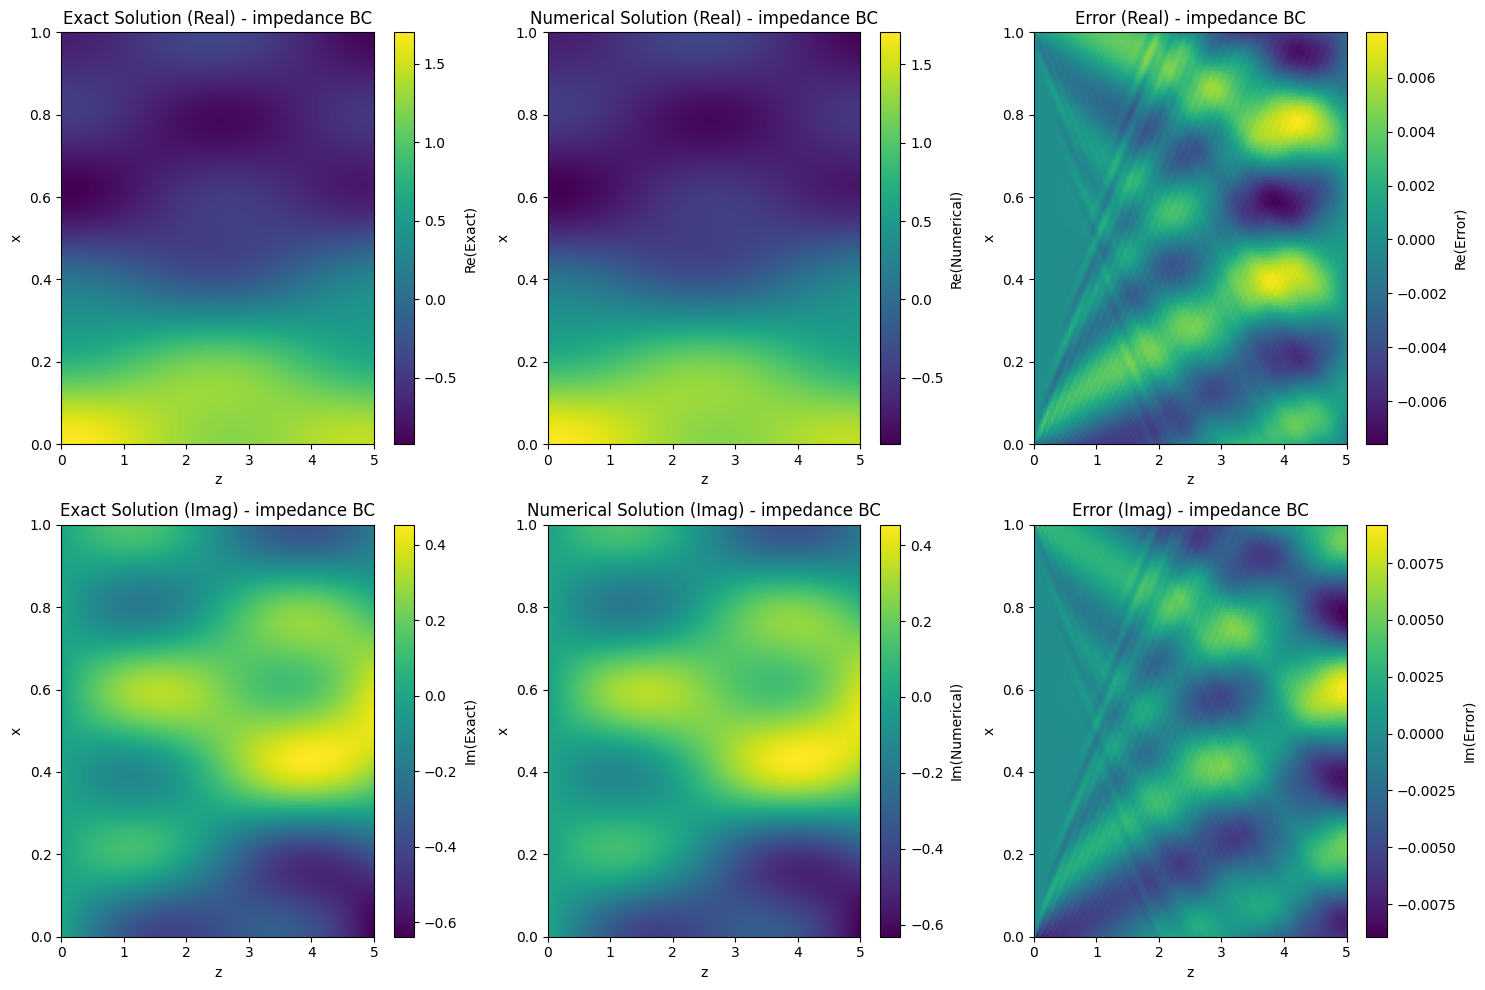

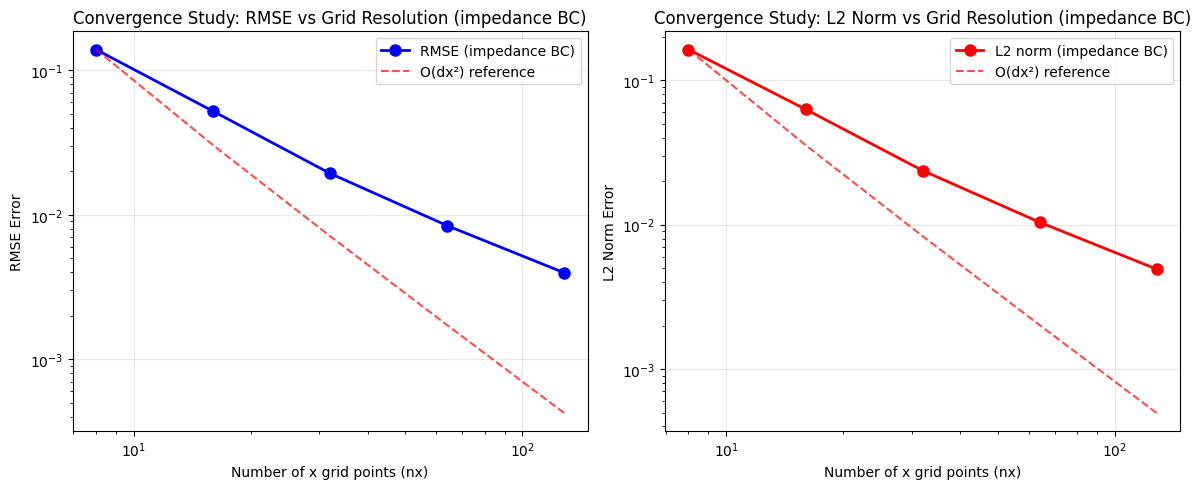


Convergence Analysis (impedance BC):
nx	nz	RMSE		Ratio	Rate	L2 Norm
------------------------------------------------------------
8	8	1.395509e-01	-	-	0.163419515646531
16	16	5.217088e-02	2.67	1.42	0.063014777074858
32	32	1.934284e-02	2.70	1.43	0.023723036720359
64	64	8.413944e-03	2.30	1.20	0.010397847740466
128	128	3.968276e-03	2.12	1.08	0.004922504454219

Final RMSE for finest grid (nx=128): 3.968276e-03
Final L2 norm for finest grid (nx=128): 0.004922504454219


In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

### PARAXIAL WAVE EQUATION WITH NEUMANN/IMPEDANCE BC - CONVERGENCE STUDY ###
# Solve paraxial wave equation on the unit interval in x
# and forwards in 'time'/beam direction z with convergence analysis
# Now supports both Neumann and impedance boundary conditions
def exact_solution(x, z, a):
    return (np.cos(np.pi*x)*np.exp(-a*(np.pi**2)*z) + 
            0.5*np.cos(2*np.pi*x)*np.exp(-4*a*(np.pi**2)*z) + 
            0.2*np.cos(5*np.pi*x)*np.exp(-25*a*(np.pi**2)*z))


def solve_paraxial_wave(nx=65, nz=33, bc_type='impedance', k=100):
    """
    Solve the paraxial wave equation with specified boundary conditions
    
    Parameters:
    - nx: number of grid points in x direction
    - nz: number of grid points in z direction  
    - bc_type: 'neumann' or 'impedance'
    - ic: initial condition type (1-5)
    - k: wave number
    - plot_individual: whether to plot individual solutions
    
    Returns:
    - u: numerical solution
    - ue: exact solution (if available)
    - x, z: grid coordinates
    - X, Z: meshgrid coordinates
    """
    
    # Problem parameters
    a = 1j/(2*k)   # Coefficient in paraxial wave equation
    
    # Set up grids and spacings
    x = np.linspace(0, 1, nx)   # x coordinates for [0,1]
    z = np.linspace(0, 5, nz)   # z coordinates for [0,2]
    dx = x[1] - x[0]  # x-spacing
    dz = z[1] - z[0]  # z-spacing

    # Initialise array for solution u and initial condition
    u = np.zeros((nx, nz), dtype=complex)   # The solution

    # Define initial condition functions
    def incidence(x_val):
        return np.cos(np.pi*x_val) + 0.5*np.cos(2*np.pi*x_val) + 0.2*np.cos(5*np.pi*x_val)

    u[:, 0] = incidence(x)     # Set initial condition

    # Set inhomogeneous impedance boundary conditions (if needed)
    if bc_type == 'impedance':
        uibc = np.zeros(nx, dtype=complex)
        uibc[0] = 1j*k*incidence(np.array([0]))[0]      # First boundary
        uibc[-1] = 1j*k*incidence(np.array([1]))[0]     # Last boundary

    # Set up matrices with problem formulated as Au^new = B*u^old (+ BCs)
    e = np.ones(nx)     # Vector of all ones
    r = 0.5*dz/(dx**2)  # Common ratio of dz and dx

    # Create sparse tridiagonal matrix - Standard Dirichlet matrix first
    diagonals = [e, -2*e, e]
    offsets = [-1, 0, 1]
    K = a*r*sp.diags(diagonals, offsets, shape=(nx, nx), format='csr')

    # Modification for Neumann matrix (exactly as in MATLAB)
    K[0, 1] = K[0, 1] + a*r          # K(1,2) = K(1,2) + a*r
    K[nx-1, nx-2] = K[nx-1, nx-2] + a*r  # K(nx,nx-1) = K(nx,nx-1) + a*r

    # Further modification for impedance matrix
    if bc_type == 'impedance':
        K[0, 0] = K[0, 0] + a*r*2*1j*k*dx      # K(1,1) modification
        K[nx-1, nx-1] = K[nx-1, nx-1] + a*r*2*1j*k*dx  # K(nx,nx) modification

    A = sp.eye(nx, format='csr') - K  # Matrix on LHS
    B = sp.eye(nx, format='csr') + K  # Matrix on RHS

    # Solve forward in 'time' z
    if bc_type == 'impedance':
        # Impedance case
        for j in range(1, nz):
            # Evaluate exact boundary values at current z
            ub_left = 1j * k * exact_solution(0, z[j], a)
            ub_right = 1j * k * exact_solution(1, z[j], a)
            ub_left_old = 1j * k * exact_solution(0, z[j-1], a)
            ub_right_old = 1j * k * exact_solution(1, z[j-1], a)

            # Build uibc vector with exact boundary values
            uibc_old = np.zeros(nx, dtype=complex)
            uibc_new = np.zeros(nx, dtype=complex)
            uibc_old[0], uibc_old[-1] = ub_left_old, ub_right_old
            uibc_new[0], uibc_new[-1] = ub_left, ub_right

            uibc = (uibc_old + uibc_new)/2

            rhs = B @ u[:, j-1] - 4*dx*a*r*uibc
            u[:, j] = spsolve(A, rhs)

    else:
        # Neumann case  
        for j in range(1, nz):
            rhs = B @ u[:, j-1]
            u[:, j] = spsolve(A, rhs)

    # Create mesh for this resolution
    Z, X = np.meshgrid(z, x)
    
    # Exact solution (only available for ic=5 with Neumann BCs)
    ue = (np.cos(np.pi*X)*np.exp(-a*np.pi**2*Z) + 
            0.5*np.cos(2*np.pi*X)*np.exp(-4*a*np.pi**2*Z) + 
            0.2*np.cos(5*np.pi*X)*np.exp(-25*a*np.pi**2*Z))

    return u, ue, x, z, X, Z


def convergence_study(bc_type='neumann', k=100):
    """
    Perform convergence study for specified boundary condition type
    """
    print(f"\n=== CONVERGENCE STUDY: {bc_type.upper()} BOUNDARY CONDITIONS ===")
    print(f"Initial condition: Wave number: k={k}")
    
    # Grid resolutions to test
    nx_values = [8, 16, 32, 64, 128]  # 2^n
    nz_values = []  # Will be calculated as nx^2 for this study
    rmse_errors = []
    l2_norms = []
    
    # Store solutions for plotting
    solutions = {}
    exact_solutions = {}
    errors = {}
    
    for idx, nx in enumerate(nx_values):
        nz = nx  
        nz_values.append(nz)  # Assuming nz = nx^2 for this study
        
        print(f"Computing solution for nx={nx}, nz={nz}")
        
        # Solve the equation
        u, ue, x, z, X, Z = solve_paraxial_wave(nx, nz, bc_type, k)
        
        # Store solutions
        solutions[nx] = {'u': u, 'X': X, 'Z': Z, 'x': x, 'z': z}
        
        exact_solutions[nx] = ue
        errors[nx] = ue - u
        
        # Calculate errors
        error = ue - u
        error_norm = np.linalg.norm(error) / np.linalg.norm(ue)
        rmse = np.sqrt(np.mean(np.abs(error)**2))
        
        rmse_errors.append(rmse)
        l2_norms.append(error_norm)

    
    # Plot solutions for the finest grid

    plot_convergence_results(nx_values,nz_values, solutions, exact_solutions, errors, 
        rmse_errors, l2_norms, bc_type)


def plot_convergence_results(nx_values, nz_values, solutions, exact_solutions, errors, 
                           rmse_errors, l2_norms, bc_type):
    """Plot convergence results and solution comparisons"""
    
    # Plot solutions for the finest grid
    nx_plot = nx_values[-1]
    nz_plot = nz_values[-1]
    u_plot = solutions[nx_plot]['u']
    ue_plot = exact_solutions[nx_plot]
    error_plot = errors[nx_plot]
    X_plot = solutions[nx_plot]['X']
    Z_plot = solutions[nx_plot]['Z']

    # Create solution comparison plot using heatmaps
    plt.figure(figsize=(15, 10))
    
    # Real parts
    plt.subplot(2, 3, 1)
    plt.imshow(np.real(ue_plot), aspect='auto', origin='lower',
               extent=[Z_plot.min(), Z_plot.max(), X_plot.min(), X_plot.max()])
    plt.colorbar(label='Re(Exact)')
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title(f'Exact Solution (Real) - {bc_type} BC')

    plt.subplot(2, 3, 2)
    plt.imshow(np.real(u_plot), aspect='auto', origin='lower',
               extent=[Z_plot.min(), Z_plot.max(), X_plot.min(), X_plot.max()])
    plt.colorbar(label='Re(Numerical)')
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title(f'Numerical Solution (Real) - {bc_type} BC')

    plt.subplot(2, 3, 3)
    plt.imshow(np.real(error_plot), aspect='auto', origin='lower',
               extent=[Z_plot.min(), Z_plot.max(), X_plot.min(), X_plot.max()])
    plt.colorbar(label='Re(Error)')
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title(f'Error (Real) - {bc_type} BC')

    # Imaginary parts
    plt.subplot(2, 3, 4)
    plt.imshow(np.imag(ue_plot), aspect='auto', origin='lower',
               extent=[Z_plot.min(), Z_plot.max(), X_plot.min(), X_plot.max()])
    plt.colorbar(label='Im(Exact)')
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title(f'Exact Solution (Imag) - {bc_type} BC')

    plt.subplot(2, 3, 5)
    plt.imshow(np.imag(u_plot), aspect='auto', origin='lower',
               extent=[Z_plot.min(), Z_plot.max(), X_plot.min(), X_plot.max()])
    plt.colorbar(label='Im(Numerical)')
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title(f'Numerical Solution (Imag) - {bc_type} BC')

    plt.subplot(2, 3, 6)
    plt.imshow(np.imag(error_plot), aspect='auto', origin='lower',
               extent=[Z_plot.min(), Z_plot.max(), X_plot.min(), X_plot.max()])
    plt.colorbar(label='Im(Error)')
    plt.xlabel('z')
    plt.ylabel('x')
    plt.title(f'Error (Imag) - {bc_type} BC')

    plt.tight_layout()
    plt.show()

    # Convergence analysis plots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.loglog(nx_values, rmse_errors, 'bo-', linewidth=2, markersize=8, 
               label=f'RMSE ({bc_type} BC)')
    plt.xlabel('Number of x grid points (nx)')
    plt.ylabel('RMSE Error')
    plt.title(f'Convergence Study: RMSE vs Grid Resolution ({bc_type} BC)')
    plt.grid(True, alpha=0.3)

    # Add theoretical convergence lines for reference
    dx_values = [1.0/(nx-1) for nx in nx_values]
    plt.loglog(nx_values, np.array(dx_values)**2 * rmse_errors[0] / dx_values[0]**2, 
               'r--', alpha=0.7, label='O(dx²) reference')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.loglog(nx_values, l2_norms, 'ro-', linewidth=2, markersize=8, 
               label=f'L2 norm ({bc_type} BC)')
    plt.xlabel('Number of x grid points (nx)')
    plt.ylabel('L2 Norm Error')
    plt.title(f'Convergence Study: L2 Norm vs Grid Resolution ({bc_type} BC)')
    plt.grid(True, alpha=0.3)
    plt.loglog(nx_values, np.array(dx_values)**2 * l2_norms[0] / dx_values[0]**2, 
               'r--', alpha=0.7, label='O(dx²) reference')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print convergence rates
    print(f"\nConvergence Analysis ({bc_type} BC):")
    print("nx\tnz\tRMSE\t\tRatio\tRate\tL2 Norm")
    print("-" * 60)
    for i, (nx,nz, rmse, l2) in enumerate(zip(nx_values, nz_values, rmse_errors, l2_norms)):
        if i > 0:
            ratio = rmse_errors[i-1] / rmse
            rate = np.log2(ratio)
            print(f"{nx}\t{nz}\t{rmse:.6e}\t{ratio:.2f}\t{rate:.2f}\t{l2:.15f}")
        else:
            print(f"{nx}\t{nz}\t{rmse:.6e}\t-\t-\t{l2:.15f}")

    print(f"\nFinal RMSE for finest grid (nx={nx_values[-1]}): {rmse_errors[-1]:.6e}")
    print(f"Final L2 norm for finest grid (nx={nx_values[-1]}): {l2_norms[-1]:.15f}")

# Main execution
if __name__ == "__main__":
    # Test both boundary condition types
    solutions = convergence_study(bc_type='impedance', k=100)